In [63]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle

from keras.models import Sequential, Model
from keras.layers import Conv2D
import os
from keras.applications.vgg16 import VGG16

In [64]:
def show(img):
    #사이즈
    plt.figure(figsize = (6,6))
    #xticks/yticks - 눈금표
    plt.xticks([])
    plt.yticks([])
    #코랩에서 안돌아감 주의
    plt.imshow(img, cmap= 'gray')
    plt.show()

In [76]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 224 #Resize images (height  = X, width = Y)
SIZE_Y = 224

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("/content/drive/MyDrive/Projects/knee/train"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        hist, bins = np.histogram(img.flatten(), 256,[0,256])

        cdf = hist.cumsum()

        # cdf의 값이 0인 경우는 mask처리를 하여 계산에서 제외
        # mask처리가 되면 Numpy 계산에서 제외가 됨
        # 아래는 cdf array에서 값이 0인 부분을 mask처리함
        cdf_m = np.ma.masked_equal(cdf,0)

        #History Equalization 공식
        cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())

        # Mask처리를 했던 부분을 다시 0으로 변환
        cdf = np.ma.filled(cdf_m,0).astype('uint8')

        img = cdf[img]
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images)


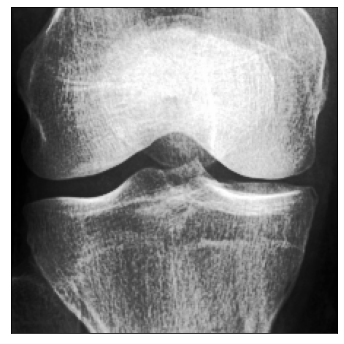

In [77]:
show(train_images[1])

In [78]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("/content/drive/MyDrive/Projects/knee/segmentation"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)



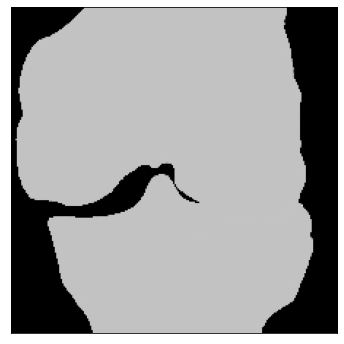

(49, 224, 224)


In [79]:
show(train_masks[1])
print(train_masks.shape)

In [80]:
#Use customary x_train and y_train variables
X_train = train_images
y_train = train_masks
y_train = np.expand_dims(y_train, axis=3) #May not be necessary.. leftover from previous code 

In [81]:
#Load VGG16 model wothout classifier/fully connected layers
#Load imagenet weights that we are going to use as feature generators
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE_X, SIZE_Y, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

#After the first 2 convolutional layers the image dimension changes. 
#So for easy comparison to Y (labels) let us only take first 2 conv layers
#and create a new model to extract features
#New model with only first 2 conv layers
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()

#Now, let us apply feature extractor to our training data
features=new_model.predict(X_train)



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

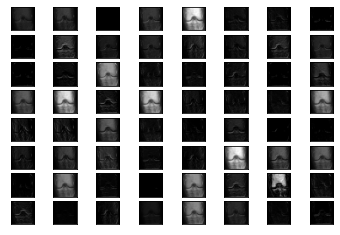

<Figure size 1440x1440 with 0 Axes>

[  0  90  97  98  85  95  96 100  51  93  89  94  99  70 109  78  92  77
  64  91  73  81 128 102  80  87 255 106  88  43 101]
97     1806904
0       616455
98       22090
96        4965
85        1652
94        1083
95        1062
99         568
64         504
93         491
51         411
90         357
91         308
77         273
92         241
89         234
109        181
128        158
73         153
70         119
100        114
78         111
102         90
81          87
88           3
43           3
101          2
87           2
80           1
106          1
255          1
Name: Label, dtype: int64


In [82]:
#Plot features to view them
square = 8
ix=1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features[0,:,:,ix-1], cmap='gray')
        ix +=1
plt.figure(figsize = (20,20))
plt.show()

#Reassign 'features' as X to make it easy to follow
X=features
X = X.reshape(-1, X.shape[3])  #Make it compatible for Random Forest and match Y labels

#Reshape Y to match X
Y = y_train.reshape(-1)

#Combine X and Y into a dataframe to make it easy to drop all rows with Y values 0
#In our labels Y values 0 = unlabeled pixels. 
dataset = pd.DataFrame(X)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())

##If we do not want to include pixels with value 0 
##e.g. Sometimes unlabeled pixels may be given a value 0.
dataset = dataset[dataset['Label'] != 0]

#Redefine X and Y for Random Forest
X_for_RF = dataset.drop(labels = ['Label'], axis=1)
Y_for_RF = dataset['Label']



In [92]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 30, random_state = 42)

# Train the model on training data
model.fit(X_for_RF, Y_for_RF) 


RandomForestClassifier(n_estimators=30, random_state=42)

In [93]:

#Save model for future use
filename = '[0104 VGG_RF_SEG]15.sav'
pickle.dump(model, open(filename, 'wb'))


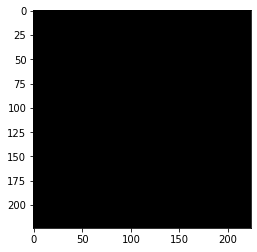

In [94]:

#Load model.... 
loaded_model = pickle.load(open(filename, 'rb'))

#Test on a different image
#READ EXTERNAL IMAGE...
test_img = cv2.imread('/content/drive/MyDrive/Projects/knee/Knee_dataset/2/9004905L.png', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img = np.expand_dims(test_img, axis=0)

#predict_image = np.expand_dims(X_train[8,:,:,:], axis=0)
X_test_feature = new_model.predict(test_img)
X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])

prediction = loaded_model.predict(X_test_feature)

#View and Save segmented image
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image, cmap='gray')
plt.imsave('/content/drive/MyDrive/Projects/knee/VGG_RF.png', prediction_image, cmap='gray')
